In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet  import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import hinge_loss

In [2]:
# Load pre-trained EfficientNetB0 without the classification head
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional base

In [3]:
# Convert to tf.keras model for feature extraction
feature_extractor = tf.keras.Model(inputs=base_model.input,outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

In [4]:
# Load dataset using tf.data
train_data = image_dataset_from_directory("D:/Sample_Run/image/bg_removed_splitted/augument_train_new", 
                                          image_size=(224, 224), batch_size=32)
test_data = image_dataset_from_directory("D:/Sample_Run/image/bg_removed_splitted/test_new", 
                                         image_size=(224, 224), batch_size=32)

Found 28800 files belonging to 48 classes.
Found 1920 files belonging to 48 classes.


In [5]:
print(len(test_data) * 32)  # Expected total number of images

1920


In [6]:
# Optional: Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_data_1 = train_data.prefetch(buffer_size=AUTOTUNE)
test_data_1 = test_data.prefetch(buffer_size=AUTOTUNE)

In [7]:
# # Function to extract features
# def extract_features(dataset, model):
#     features, labels = [], []
#     for batch_images, batch_labels in dataset:
#         batch_features = model.predict(batch_images)
#         features.append(batch_features)
#         labels.append(batch_labels.numpy())
#     return np.vstack(features), np.hstack(labels)

In [8]:
# # Extract features using EfficientNetB0
# X_train, y_train = extract_features(train_data_1, feature_extractor)
# X_test, y_test = extract_features(test_data_1, feature_extractor)

In [9]:
# # Save features to disk
# np.savez("D:/Sample_Run/image/FeatureExtraction_Efficient/features_train_new.npz", X=X_train, y=y_train)
# np.savez("D:/Sample_Run/image/FeatureExtraction_Efficient/features_test_new.npz", X=X_test, y=y_test)

In [7]:
# Load saved features
train_data_z = np.load("D:/Sample_Run/image/FeatureExtraction_Efficient/features_train_new.npz")
X_train, y_train = train_data_z['X'], train_data_z['y']

test_data_z = np.load("D:/Sample_Run/image/FeatureExtraction_Efficient/features_test_new.npz")
X_test, y_test = test_data_z['X'], test_data_z['y']


In [8]:
print(test_data_z.files)  # Shows all keys in the .npz file


['X', 'y']


In [9]:
# import numpy as np

# Count class distribution before transformation
original_counts = np.zeros(48)  # Replace num_classes with the actual number of classes
for _, label in test_data:  # test_data before feature transformation
    for l in label.numpy():
        original_counts[l] += 1
print("Original class distribution:", original_counts)

# Count class distribution after transformation
transformed_counts = np.zeros(48)
for label in y_test:  # test_data after transformation
    transformed_counts[label] += 1
print("Transformed class distribution:", transformed_counts)


Original class distribution: [40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]
Transformed class distribution: [40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]


In [10]:
print(y_test.shape)
print(X_test.shape)

(1920,)
(1920, 1280)


In [14]:
print("Feature shape:", test_data_z["X"].shape)  # Features
print("Label shape:", test_data_z["y"].shape)    # Labels
print(y_test)

Feature shape: (1920, 1280)
Label shape: (1920,)
[38 12 26 ...  1  4 31]


In [15]:
print("Train feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)


Train feature shape: (28800, 1280)
Test feature shape: (1920, 1280)


In [11]:
# Initialize scaler
scaler = StandardScaler()

In [12]:

# Scale training features before fitting SVM
X_train_scaled = scaler.fit_transform(X_train)  

X_test_scaled = scaler.transform(X_test)


In [18]:
print(X_test_scaled.shape)

(1920, 1280)


In [13]:
import joblib

In [ ]:
# 2️⃣ Train SGD SVM Model
from tqdm import tqdm
# from sklearn.linear_model import SGDClassifier
import pickle



# Initialize SVC with RBF kernel
svc_rbf_eff = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42,decision_function_shape='ovr',probability=False)

# Manually fit the model with tqdm
for epoch in tqdm(range(1), desc="Training SVM"):
    svc_rbf_eff.fit(X_train_scaled, y_train)

# Lists to store accuracy for plotting
history = {'train_acc': [], 'val_acc': []}

# print(f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# Save the training history
with open('svc_rbf_training_history_new.pkl', 'wb') as f:
    pickle.dump(history, f)



# Save the trained model
joblib.dump(svc_rbf_eff, "svc_rbf_efficeint_new.pkl")

Training SVM: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [15:51<00:00, 951.41s/it]


['svc_rbf_efficeint_new.pkl']

In [14]:
# Load the model later
svc_rbf_eff = joblib.load("svc_rbf_efficeint_new.pkl")

In [21]:
 # Get decision function scores for test data
decision_values = svc_rbf_eff.decision_function(X_test_scaled)

# Compute hinge loss for multiclass
hloss = hinge_loss(y_test, decision_values, labels=svc_rbf_eff.classes_)
print("Multiclass Hinge Loss:", hloss)

Multiclass Hinge Loss: 0.006783385539206943


In [23]:
# Evaluate on validation and test sets
y_train_pred = svc_rbf_eff.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
print(f"Train Accuracy: {train_accuracy:.2f}%")

Train Accuracy: 99.61%


In [26]:
# Evaluate on validation and test sets
y_test_pred = svc_rbf_eff.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.69%


In [25]:
from sklearn.metrics import classification_report


# Classification report
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred, digits=4))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    0.9750    0.9873        40
           2     1.0000    1.0000    1.0000        40
           3     1.0000    0.9750    0.9873        40
           4     1.0000    1.0000    1.0000        40
           5     1.0000    1.0000    1.0000        40
           6     1.0000    1.0000    1.0000        40
           7     1.0000    1.0000    1.0000        40
           8     1.0000    1.0000    1.0000        40
           9     1.0000    1.0000    1.0000        40
          10     1.0000    1.0000    1.0000        40
          11     1.0000    1.0000    1.0000        40
          12     1.0000    1.0000    1.0000        40
          13     1.0000    1.0000    1.0000        40
          14     1.0000    0.9750    0.9873        40
          15     1.0000    1.0000    1.0000        40
          16     1.0000    1.0000    1.0000  

In [16]:
unique_labels = test_data.class_names
print(unique_labels)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9']


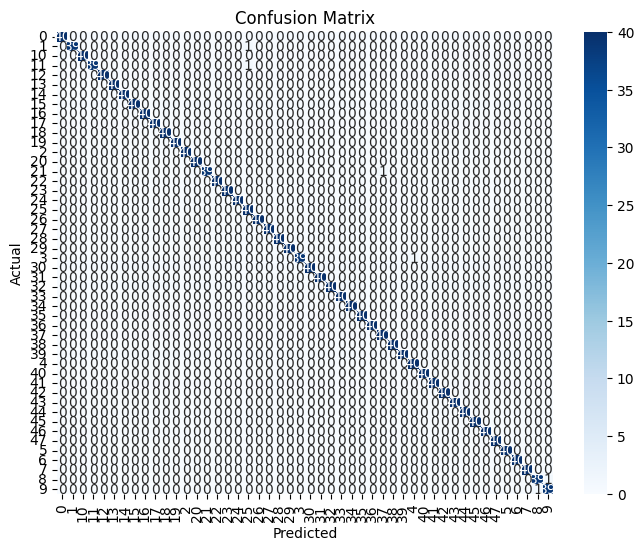

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)  # Ensure y_test and y_pred are defined

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:
# Compute confusion matrix
# cm = confusion_matrix(y_test, y_test_pred)

# # Print TP, TN, FP, FN for each class
# num_classes = cm.shape[0]

metrics = {}

for i in range(48):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: actual class i but predicted as others
    fp = np.sum(cm[:, i]) - tp  # False Positives: predicted as class i but actually others
    tn = np.sum(cm) - (tp + fp + fn)  # True Negatives: all others

    metrics[f"Class {i}"] = {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

# Print the results
for class_labels, values in metrics.items():
    print(f"{class_labels}: TP={values['TP']}, TN={values['TN']}, FP={values['FP']}, FN={values['FN']}")

Class 0: TP=40, TN=1880, FP=0, FN=0
Class 1: TP=39, TN=1880, FP=0, FN=1
Class 2: TP=40, TN=1880, FP=0, FN=0
Class 3: TP=39, TN=1880, FP=0, FN=1
Class 4: TP=40, TN=1880, FP=0, FN=0
Class 5: TP=40, TN=1880, FP=0, FN=0
Class 6: TP=40, TN=1880, FP=0, FN=0
Class 7: TP=40, TN=1880, FP=0, FN=0
Class 8: TP=40, TN=1880, FP=0, FN=0
Class 9: TP=40, TN=1880, FP=0, FN=0
Class 10: TP=40, TN=1880, FP=0, FN=0
Class 11: TP=40, TN=1880, FP=0, FN=0
Class 12: TP=40, TN=1880, FP=0, FN=0
Class 13: TP=40, TN=1880, FP=0, FN=0
Class 14: TP=39, TN=1880, FP=0, FN=1
Class 15: TP=40, TN=1880, FP=0, FN=0
Class 16: TP=40, TN=1880, FP=0, FN=0
Class 17: TP=40, TN=1880, FP=0, FN=0
Class 18: TP=40, TN=1878, FP=2, FN=0
Class 19: TP=40, TN=1880, FP=0, FN=0
Class 20: TP=40, TN=1880, FP=0, FN=0
Class 21: TP=40, TN=1880, FP=0, FN=0
Class 22: TP=40, TN=1880, FP=0, FN=0
Class 23: TP=39, TN=1880, FP=0, FN=1
Class 24: TP=40, TN=1880, FP=0, FN=0
Class 25: TP=40, TN=1880, FP=0, FN=0
Class 26: TP=40, TN=1880, FP=0, FN=0
Class 27: T

In [17]:
odia_numerals = {
    '0': '୦', '1': '୧', '2': '୨', '3': '୩', '4': '୪', '5': '୫', '6': '୬', '7': '୭', '8': '୮', '9': '୯',
    '10': 'ଅ', '11': 'ଆ', '12': 'ଇ', '13': 'ଉ', '14': 'ଋ', '15': 'ଏ', '16': 'ଐ', '17': 'ଓ', '18': 'ଔ',
    '19': 'କ', '20': 'ଖ', '21': 'ଗ', '22': 'ଘ', '23': 'ଚ', '24': 'ଛ', '25': 'ଜ', '26': 'ଝ', '27': 'ଟ',
    '28': 'ଠ', '29': 'ଡ', '30': 'ଢ', '31': 'ଣ', '32': 'ତ', '33': 'ଥ', '34': 'ଦ', '35': 'ଧ', '36': 'ନ',
    '37': 'ପ', '38': 'ଫ', '39': 'ବ', '40': 'ଭ', '41': 'ମ', '42': 'ର', '43': 'ଳ', '44': 'ସ', '45': 'ହ',
    '46': 'ୟ', '47': 'କ୍ଷ'
}

1/1 [==============================] - 0s 320ms/step
(1, 1280)
Decision function output: [[45.31759711 27.21492837 22.75507154  7.69322638 44.31812807 43.32166161
  24.83143083 21.7230295  12.69317914 33.27170396 46.32254292 13.70139316
  35.30016982 30.28402017 30.2720753  10.69453932 47.32069673 42.31427616
  37.30520092 41.3131961  33.26550544 33.29878605 29.27513037 19.71605689
  14.70041325 16.71612286  4.68569659 13.70238843 37.30771193  7.6974486
   8.69853884 40.30486167 37.30158915  2.685135   28.27207742  1.68361788
  14.73620875 39.30647107 14.70034889 16.72250198 -0.31997764 18.7261361
  19.72294313 27.25061335 17.73173189  6.69252442  3.68357954  0.68042987]]


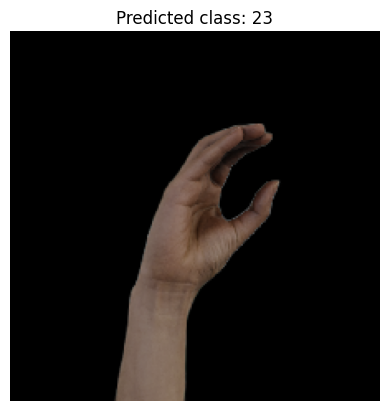

Predicted class: ଚ


In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image


# Ensure sgd_svm is already trained in your script before calling this function

def predict_image(image_path, feature_extractor, model,scaler):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # img_array /= 255.0  # Normalize
    img_array = preprocess_input(img_array)  


    # Extract features using ResNet50
    features = feature_extractor.predict(img_array)
    features = np.array(features).reshape(1, -1)
    print(features.shape)

     # Scale test features before prediction
    features_scaled = scaler.transform(features)  # Individual image feature
    predicted_class = model.predict(features_scaled)
    print("Decision function output:", model.decision_function(features_scaled))

    # Show image and prediction
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    
    # Optional: map numeric label to class name
    if unique_labels:
        label = unique_labels[predicted_class[0]]
    else:
        label = predicted_class[0]

    odia_label = odia_numerals.get(label, label)
    plt.title(f"Predicted class: {label}")
    plt.show()

    return odia_label

# Provide your image path
image_path = r"D:/Sample_Run/archive/Test_Alphabet_bgrmv/C/2d214dc6-9d41-412b-a7db-330c0fb137d0.rgb_0000.png"

# Ensure `sgd_svm` and `feature_extractor` are defined and trained before calling this function
predicted_class = predict_image(image_path, feature_extractor, svc_rbf_eff,scaler)
print(f"Predicted class: {predicted_class}")


In [24]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image


def run_batch_prediction(test_dir, feature_extractor, model, scaler, label_map=None):
    results = []

    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Load and preprocess the image
                img = image.load_img(image_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)

                # Extract features and scale
                features = feature_extractor.predict(img_array)
                features = np.array(features).reshape(1, -1)
                features_scaled = scaler.transform(features)

                # Predict
                predicted_class = model.predict(features_scaled)[0]
                
                # Convert predicted index to label (if using label_map)
                pred_label = label_map[predicted_class] if label_map else str(predicted_class)

                # Store result
                results.append({
                    'Image': image_name,
                    'Actual': class_name,
                    'Predicted': pred_label,
                    'Correct': str(class_name) == str(pred_label)
                })

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Create DataFrame
    df_results = pd.DataFrame(results)
    accuracy = df_results['Correct'].mean() * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")

    return df_results

# Example usage:
test_dir = r"D:/Sample_Run/image/bg_removed_splitted/test_new"
df = run_batch_prediction(test_dir, feature_extractor, svc_rbf_eff, scaler, label_map=unique_labels)
print(df.head())

# Optional: Save to Excel or CSV
df.to_csv("eff_prediction_results_new.csv", index=False)


1/1 [==============================] - 0s 247ms/step

Overall Accuracy: 99.79%
      Image Actual Predicted  Correct
0   0_0.png      0         0     True
1   0_1.png      0         0     True
2  0_10.png      0         0     True
3  0_11.png      0         0     True
4  0_12.png      0         0     True


In [28]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred)


0.9968085106382979

In [29]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_test_pred)


0.9968098914153671

In [30]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, y_test_pred)

0.003125

In [32]:
# # 6. Class-wise Support
# report = classification_report(y_test, y_test_pred, output_dict=True)
# support_per_class = {label: int(metrics['support']) for label, metrics in report.items() if label.isdigit()}
# print(f"Class-wise Support: {support_per_class}")

In [ ]:
if 'ଉ' == 'ଉ':
    print("ଉ")